In [73]:
# 필요한 것들 한번에 임포트해오기

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

In [74]:
#train caption 파일 불러오기
# 예제 코드 -> 대부분 함수로 선언해서 값 return 받는 형태
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

filename = "C:/Users/User/Desktop/객체_플젝/train_captions.txt"

doc = load_doc(filename)
print(doc[:300])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to


In [75]:
def load_descriptions(doc):
    mapping = dict() #train 데이터를 딕셔너리로
    # 문장(행) 처리단계
    for line in doc.split('\n'):  # 라인 개행 -> 스페이스 바로 구분
            tokens = line.split()
            if len(line) < 2:
                    continue
        # 첫번째 토큰이 image id이면 -> 그 뒷부분은 캡션
            image_id, image_desc = tokens[0], tokens[1:]
        # image id에서 파일 네임 추출
            image_id = image_id.split('.')[0]
            image_desc = ' '.join(image_desc)

            if image_id not in mapping:
                    mapping[image_id] = list()
            
        # description 저장
            mapping[image_id].append(image_desc)
    return mapping

# 함수 리턴값을 변수descriptions 에 저장
descriptions = load_descriptions(doc)
print('불러온 descriptions: %d ' % len(descriptions))

불러온 descriptions: 6000 


아래 두 cell은 잘 나오는지 확인하는 코드

In [76]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [77]:
descriptions['1000268201_693b08cb0e']

['child in a pink dress is climbing up a set of stairs in an entry way .',
 'girl going into a wooden building .',
 'little girl climbing into a wooden playhouse .',
 'little girl climbing the stairs to her playhouse .',
 'little girl in a pink dress going into a wooden cabin .']

In [78]:
#데이터 클리닝 함수 선언 (구두점 제거등,,)
def clean_descriptions(descriptions):
        # translation table 이용하여 cleaning 시행
        table = str.maketrans('', '', string.punctuation)
        for key, desc_list in descriptions.items():
            for i in range(len(desc_list)):
                desc = desc_list[i] # 리스트화
                desc = desc.split()
                desc = [word.lower() for word in desc] # 모든 단어를 소문자로
                # 구두점 제거
                desc = [w.translate(table) for w in desc]
                # hanging 's' and 'a' 제거 -> ??
                desc = [word for word in desc if len(word)>1]
                # remove tokens with numbers in them 
                desc = [word for word in desc if word.isalpha()]
                # 문자열 형태로 저장
                desc_list[i] =  ' '.join(desc)

# 정의한 함수로 description clean
clean_descriptions(descriptions)

# clean 된 caption 예시
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [79]:
# clean된 description 바탕으로 단어 사전 생성하는 함수 정의

def to_vocabulary(descriptions):
        # clean된 description -> list
        all_desc = set()
        for key in descriptions.keys():
            [all_desc.update(d.split()) for d in descriptions[key]]
        return all_desc

vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 7600


In [80]:
# 파일에 description 저장
def save_descriptions(descriptions, filename):
        lines = list()
        for key, desc_list in descriptions.items():
            for desc in desc_list:
                lines.append(key + ' ' + desc)
        data = '\n'.join(lines)
        file = open(filename, 'w')
        file.write(data)
        file.close()

save_descriptions(descriptions, 'descriptions.txt')

In [81]:
# photo identifiers 리스트 호출
def load_set(filename):
        doc = load_doc(filename)
        dataset = list()
        for line in doc.split('\n'):
            # 비어있는 라인 skip
            if len(line) < 1:
                continue

            identifier = line.split('.')[0]
            dataset.append(identifier)
        return set(dataset)

# train 데이터 불러오기
filename = "C:/Users/User/Desktop/객체_플젝/train_captions.txt"
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [82]:
images = "C:/Users/User/Desktop/객체_플젝/archive/Images/"
# 모든이미지 load
img = glob.glob(images + '*.jpg')

In [83]:
#train에 사용할 data 리스트 생성

train_images_file = "C:/Users/User/Desktop/객체_플젝/train_captions.txt"
# train image 이름 추출
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# train 이미지 리스트 생성
train_img = []
for i in img: 
    if i[len(images):] in train_images:
        train_img.append(i) 

In [84]:
#test에 사용할 data 리스트 생성
test_images_file = "C:/Users/User/Desktop/객체_플젝/test_captions.txt"
# test image 이름 추출
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# test 이미지 리스트 생성
test_img = []
for i in img: 
    if i[len(images):] in test_images: 
        test_img.append(i)

In [85]:
# cleaned description 메모리에 불러오기
def load_clean_descriptions(filename, dataset):
        doc = load_doc(filename)
        descriptions = dict()
        for line in doc.split('\n'):
            tokens = line.split()
            image_id, image_desc = tokens[0], tokens[1:]
            if image_id in dataset:
                if image_id not in descriptions:
                    descriptions[image_id] = list()
                desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
                descriptions[image_id].append(desc)
        return descriptions

#train descriptions 생성끝(clean 처리 완료) 
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [86]:
def preprocess(image_path):
    # Inceptionv3 model 쓰기위해 이미지를 299x299 크기로 변환하는 단계
    img = image.load_img(image_path, target_size=(299, 299))
    # Inceptionv3 model 활용을 위해 PIL image -> 3-dimensions
    x = image.img_to_array(img)
    # 차원추가
    x = np.expand_dims(x, axis=0)
    # 이미지 전처리 - nception module에 있는 preprocess_input() 함수사용
    x = preprocess_input(x)
    return x

# InceptionV3 model 로드
model = InceptionV3(weights='imagenet')
# InceptionV3 model output layer 제거해서 새 모델 생성
model_new = Model(model.input, model.layers[-2].output)

In [87]:
# 이미지를 길이 2048짜리의 벡터로 변환하기 위한 encoding 함수 정의
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [88]:
# 피클 파일 생성 오류 계속 발생
# 그냥 넘어가고 정휴님이 보내주신 pkl 파일 사용하기
#현재 셀 + 아래 3개 셀 무시
'''
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)
#print(encoding_train)
'''

'\nstart = time()\nencoding_train = {}\nfor img in train_img:\n    encoding_train[img[len(images):]] = encode(img)\nprint("Time taken in seconds =", time()-start)\n#print(encoding_train)\n'

In [89]:
# Save the bottleneck train features to disk
#import pickle

#with open("C:/Users/User/Desktop/객체_플젝/encoded_train_images.pkl", "wb") as encoded_pickle_w:
 #   pickle.dump(encoding_train, encoded_pickle_w)

# Load pickle file    
#with open("C:/Users/User/Desktop/객체_플젝/encoded_train_images.pkl", "rb") as encoded_pickle_r:
 #   data=pickle.load(encoded_pickle_r)
#print(data)

In [90]:
#test 이미지 인코딩 과정
start = time()
encoding_test = {}
for img in test_img:
  encoding_test[img[len(images):]] = encode(img)
# 처리 소요 시간 확인 -> 파일 제대로 로드 안되는 것을 확인했음
print("Time taken in seconds =", time()-start)

Time taken in seconds = 0.014708757400512695


In [91]:
# test features -> pickle 파일로 디스크에 저장
#import pickle

#with open("C:/Users/User/Desktop/객체_플젝/encoded_test_images.pkl", "wb") as encoded_pickle:
# pickle.dump(encoding_test, encoded_pickle)

In [92]:
train_features = load(open("C:/Users/User/Desktop/객체_플젝/encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [93]:
#train caption 리스트 생성
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [94]:
# 빈출 어휘만 추출
# 코퍼스(말뭉치)에서 10번 이상 나타나는 단어만 뽑아내어 고려
word_count_threshold = 10 # 10회로 지정
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

# 등장횟수 만족하는 word만 vocab에 저장
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7603 -> 1652


In [108]:
#단어를 인덱스로 변환
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1
    
vocab_size = len(ixtoword) + 1 # 추가된 0 때문에 1 더하기
vocab_size

1653

In [109]:
# 딕셔너리에서 리스트로 변환

def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# 가장 많은 단어 사용한 캡션 길이
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# 최대 캡션 길이 정하기
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)
# 왜 34가 아니라 33으로 나오지..? train dataset을 잘못처리한건가

Description Length: 33


In [110]:
# GENERATOR !!!!!!!!
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # input 시퀀스랑 output 시퀀스로 분리
                    in_seq, out_seq = seq[:i], seq[i]
                    # 인풋시퀀스 제로 패딩해서 길이 max로 맞추기
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # 아웃풋 시퀀스 인코딩
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
   
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

In [111]:
# Glove Embedding 단계

# Load Glove vectors
glove_dir = 'C:/Users/User/Downloads/glove.6B.200d.txt'
embeddings_index = {} 
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

Found 400000 word vectors.


(1653, 200)

In [112]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 33)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 33, 200)      330600      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_4 (Dropout)             (None, 2048)         0           input_6[0][0]                    
____________________________________________________________________________________________

In [113]:
### OS에러 발생

model.layers[2]

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

model.compile(loss='categorical_crossentropy', optimizer='adam')

epochs = 10
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('C:/Users/User/Desktop/객체_플젝' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 834s 417ms/step - loss: 4.2032
Epoch 1/1
2000/2000 [==============================] - 905s 452ms/step - loss: 3.4958
Epoch 1/1
2000/2000 [==============================] - 942s 471ms/step - loss: 3.2717
Epoch 1/1
2000/2000 [==============================] - 7123s 4s/step - loss: 3.1365
Epoch 1/1
2000/2000 [==============================] - 495s 248ms/step - loss: 3.0390
Epoch 1/1
2000/2000 [==============================] - 578s 289ms/step - loss: 2.9673
Epoch 1/1
2000/2000 [==============================] - 633s 316ms/step - loss: 2.9095
Epoch 1/1
2000/2000 [==============================] - 635s 317ms/step - loss: 2.8578
Epoch 1/1
2000/2000 [==============================] - 578s 289ms/step - loss: 2.8160
Epoch 1/1
2000/2000 [==============================] - 559s 280ms/step - loss: 2.7816


In [114]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('C:/Users/User/Desktop/객체_플젝' + str(i) + '.h5')

Epoch 1/1
2000/2000 [==============================] - 455s 227ms/step - loss: 2.7495
Epoch 1/1
2000/2000 [==============================] - 485s 243ms/step - loss: 2.7264
Epoch 1/1
2000/2000 [==============================] - 501s 251ms/step - loss: 2.6993
Epoch 1/1
2000/2000 [==============================] - 509s 254ms/step - loss: 2.6771
Epoch 1/1
2000/2000 [==============================] - 546s 273ms/step - loss: 2.6571
Epoch 1/1
2000/2000 [==============================] - 534s 267ms/step - loss: 2.6379
Epoch 1/1
2000/2000 [==============================] - 540s 270ms/step - loss: 2.6223
Epoch 1/1
2000/2000 [==============================] - 582s 291ms/step - loss: 2.6092
Epoch 1/1
2000/2000 [==============================] - 564s 282ms/step - loss: 2.5949
Epoch 1/1
2000/2000 [==============================] - 542s 271ms/step - loss: 2.5844


In [115]:
from keras.optimizers import Adam, RMSprop

keras.optimizers.Adam(lr=0.001)
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [116]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    # model.save('C:/Users/User/Desktop/객체_플젝' + str(i) + '.h5')

Epoch 1/1
1000/1000 [==============================] - 446s 446ms/step - loss: 2.5411
Epoch 1/1
1000/1000 [==============================] - 490s 490ms/step - loss: 2.5195
Epoch 1/1
1000/1000 [==============================] - 493s 493ms/step - loss: 2.5085
Epoch 1/1
1000/1000 [==============================] - 484s 484ms/step - loss: 2.4989
Epoch 1/1
1000/1000 [==============================] - 466s 466ms/step - loss: 2.4888
Epoch 1/1
1000/1000 [==============================] - 469s 469ms/step - loss: 2.4779
Epoch 1/1
1000/1000 [==============================] - 484s 484ms/step - loss: 2.4666
Epoch 1/1
1000/1000 [==============================] - 476s 476ms/step - loss: 2.4587
Epoch 1/1
1000/1000 [==============================] - 489s 489ms/step - loss: 2.4517
Epoch 1/1
1000/1000 [==============================] - 467s 467ms/step - loss: 2.4410


In [117]:
model.save_weights('C:/Users/User/Desktop/객체_플젝30.h5')

In [118]:
model.load_weights('C:/Users/User/Desktop/객체_플젝30.h5')

In [119]:
with open("C:/Users/User/Desktop/객체_플젝/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [120]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [121]:
pic_list=list()

pic_list.append('3510218982_318f738b76.jpg')
pic_list.append('3513362553_5fc5779e20.jpg')
pic_list.append('3516267455_ca17cc1323.jpg')
pic_list.append('3518675890_2f65e23ff9.jpg')
pic_list.append('3520321387_710ab74cda.jpg')

pic_list.append('3525417522_7beb617f8b.jpg')
pic_list.append('3535284878_f90f10236e.jpg')
pic_list.append('3537520829_aab733e16c.jpg')
pic_list.append('3538686658_30afc75f02.jpg')
pic_list.append('3540598210_972f0ff573.jpg')

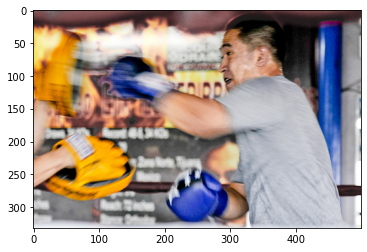

Greedy: man is wearing black shirt and holding basketball


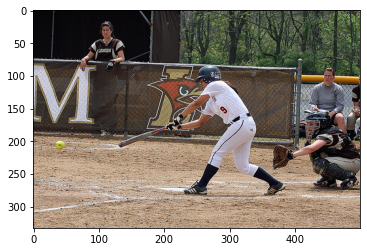

Greedy: baseball player in white is sliding onto base


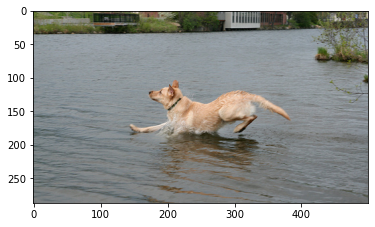

Greedy: dog is running through the water


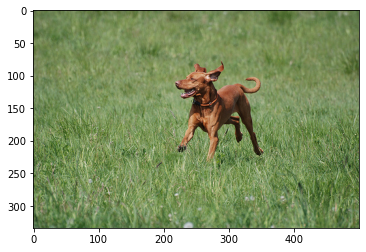

Greedy: brown dog is running through the grass with tennis ball in its mouth


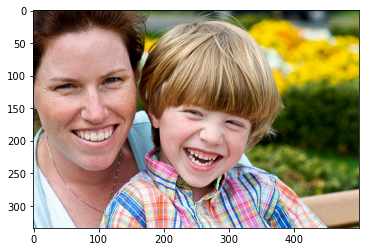

Greedy: girl in pink and white costumes is holding toy animal


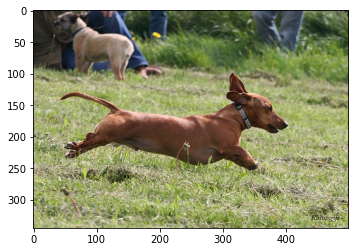

Greedy: brown dogs are playing with toy


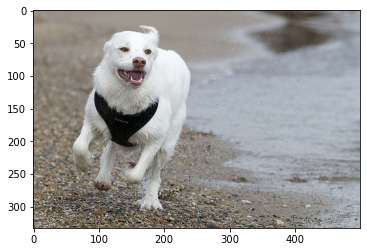

Greedy: dog is running through the water


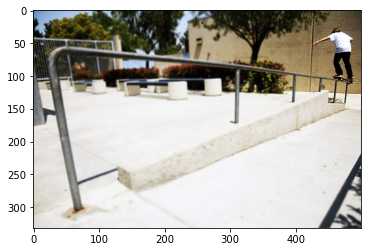

Greedy: man is jumping his bicycle over wall


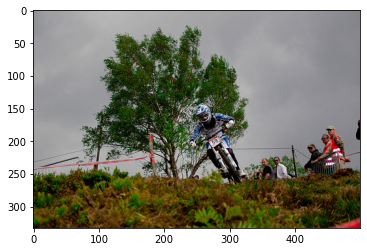

Greedy: man on bike is jumping off ramp


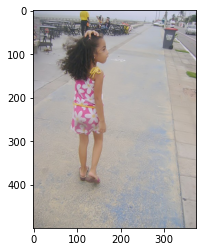

Greedy: girls are playing in the water


In [122]:
for z in range(0,10,1):
    #pic is image_id like '3516267455_ca17cc1323.jpg'
    #pic = list(encoding_test.keys())[z]
    pic=pic_list[z]
    #image is reshaped vector of image
    image = encoding_test[pic].reshape((1,2048))
    #images+pic is path of image that has image_id saved at pic
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))